In [33]:
%pip install h5py shortprint matplotlib numpy pandas seaborn statsmodels --quiet

Note: you may need to restart the kernel to use updated packages.


In [1]:
import h5py
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
values = []

for i in range (5,10):
    f = h5py.File('../data/ghi_201{}.h5'.format(i), 'r')
    value = f['/set']
    values.append(value)

del values[1] # year 2016 doesn't have the save shape
print(values)

[<HDF5 dataset "set": shape (35040, 386, 371), type "|u1">, <HDF5 dataset "set": shape (35040, 386, 371), type "|u1">, <HDF5 dataset "set": shape (35040, 386, 371), type "|u1">, <HDF5 dataset "set": shape (35040, 386, 371), type "|u1">]


In [4]:
print(values[0].shape)

(35040, 386, 371)


In [5]:
# test for one coordinate :

serie = values[0][:,200,200]

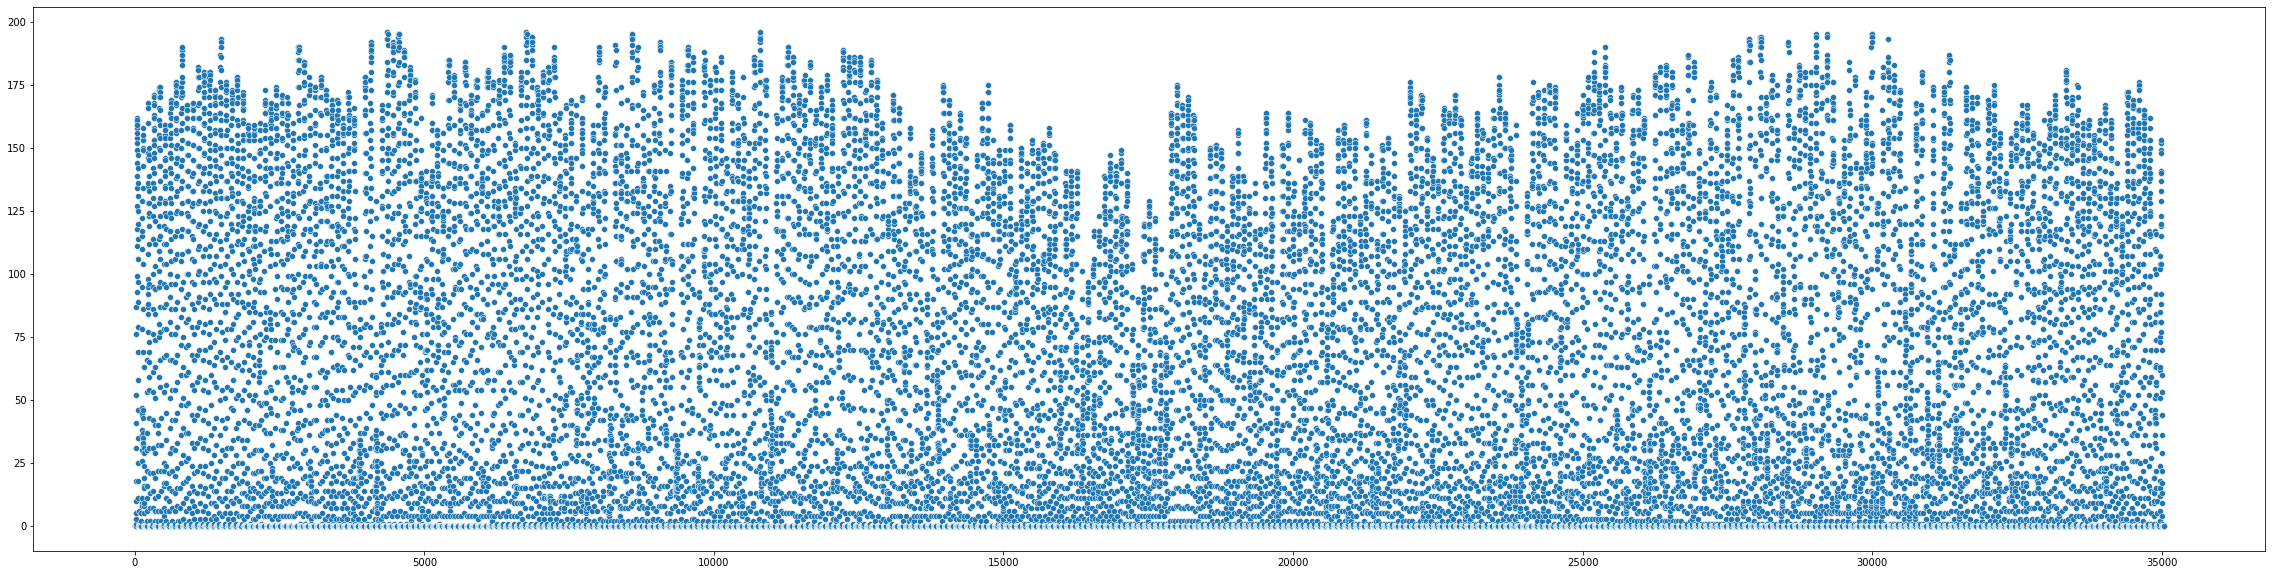

In [8]:
# plot one year for this coordinate
fig, ax = plt.subplots(figsize=(40,10))
x=serie
sns.scatterplot(x=list(range(x.shape[0])),y=x,ax=ax);

In [10]:
# Perform necessary test for one coordinate over a year

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [11]:
adfuller_test(serie, name="year 2015, coord 200,200")


    Augmented Dickey-Fuller Test on "year 2015, coord 200,200" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -51.6169
 No. Lags Chosen       = 52
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


In [12]:
# Todo : test other model and grid search coeff
from statsmodels.tsa.arima.model import ARIMA

ARIMAmodel = ARIMA(serie, order = (2, 2, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(35040)

d:\Documents\irradiance\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


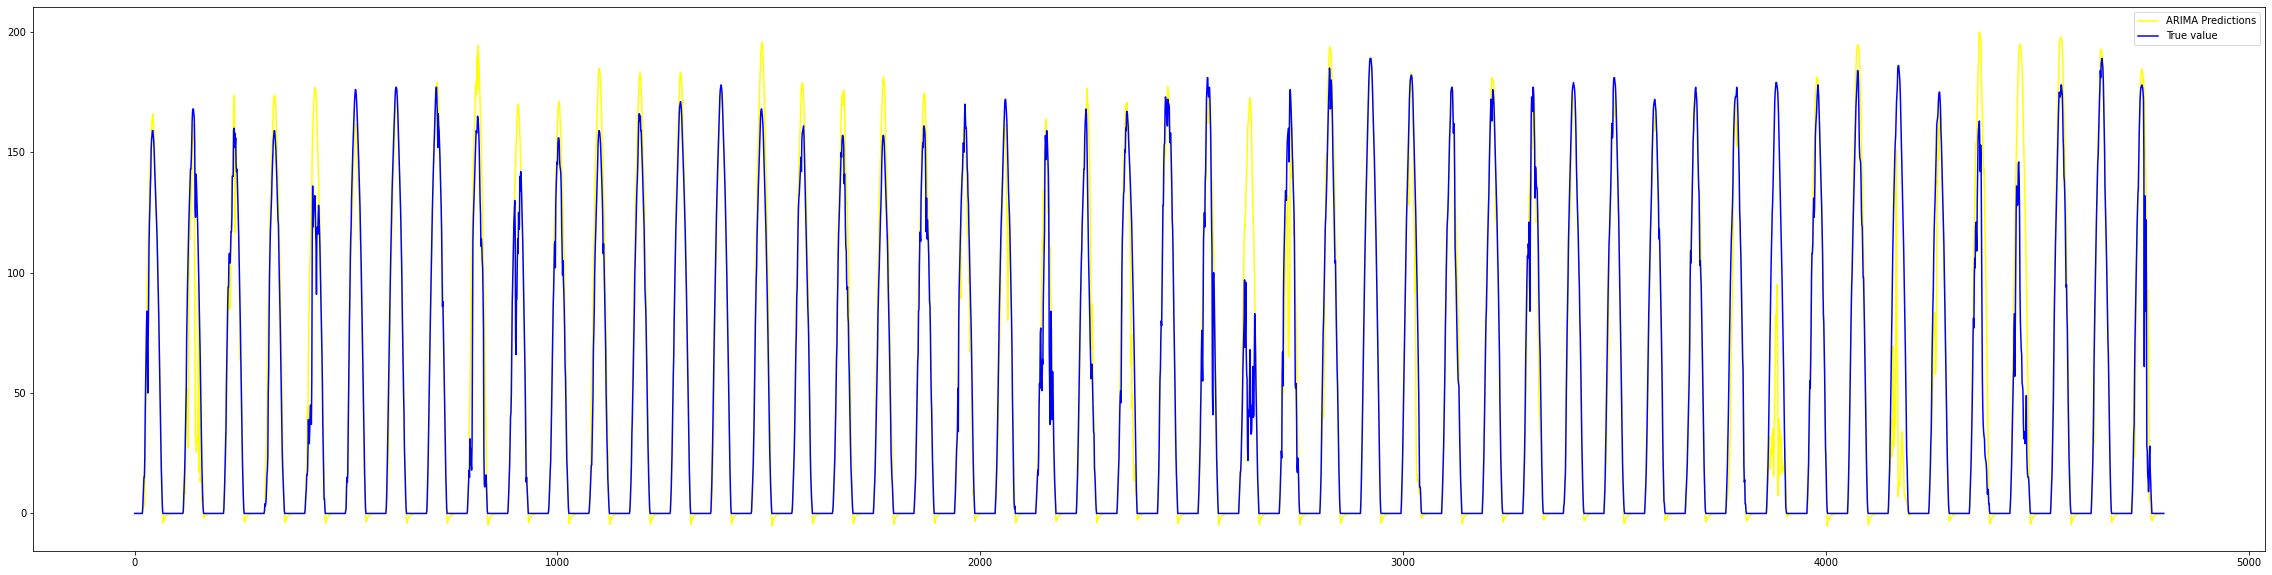

In [16]:
# Plot prediction over one year and compare with true value

y_pred = ARIMAmodel.predict(start = 0, end = 35040)

plt.figure(figsize=(40,10))
max_values = 50*96
plt.plot(y_pred[:max_values], color='Yellow', label = 'ARIMA Predictions')
plt.plot(values[1][:max_values,200,200], color= "Blue", label = "True value")
plt.legend()
plt.show()

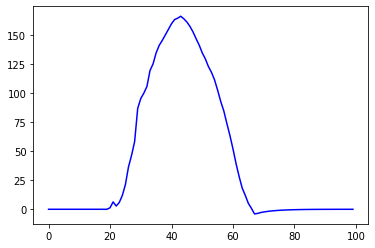

In [18]:
# plot one day for this coordinate
plt.plot(y_pred[0:100], color='blue', label = 'ARIMA Predictions')
plt.show()